In [1]:
import sys
import sqlite3

import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_selection import RFECV, RFE
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sys.path.append('/home/pooya/w/DroughtMonitoringIran/')

DATABASE_PATH = "./database/database.db"

conn = sqlite3.connect(DATABASE_PATH)

data = pd.read_sql(sql='SELECT * FROM data', con=conn)

conn.close()

In [3]:
di = 'SPEI'
di_scale = 9

selected_columns = [
    'Station_Name', 'Station_ID',
    'Station_Latitude', 'Station_Longitude', 'Station_Elevation',
    'Date',
    f'{di}_{di_scale}',
    'ERA5_Precipitation',
    'GPM_Precipitation',
    'TRMM_Precipitation',
    'TERRACLIMATE_Precipitation',
    'PERSIANNCDR_Precipitation',
    f'GPM_{di}_{di_scale}',
    f'ERA5_{di}_{di_scale}',
    'PET_MOD16A2GF',
    'NDVI', 'EVI',
    'LSTDay', 'LSTNight', 'LST',
    'PCI_GPM', 'VCI', 'TCI', 'VHI', 'CI_GPM',
 ]

In [4]:
df = data.filter(items=selected_columns)
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m')
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Station_ID'] = df['Station_ID'].astype('category')
df['Year'] = df['Year'].astype('category')
df['Month'] = df['Month'].astype('category')

In [5]:
# selected_stations = ['Ramsar', 'Nowshahr']
selected_stations = ['Siahbisheh', 'Kiyasar', 'Kojur', 'Baladeh', 'Alasht']
# selected_stations = ['Babolsar', 'Gharakhil', 'Sari', 'Sari (dasht-e-naz airport)', 'Galugah', 'Bandar-e-amirabad', 'Amol', 'Polsefid']

start_date = '2006-09'
end_date = '2023-10'

df = df.query("Station_Name in @selected_stations and Date >= @start_date and Date < @end_date")

In [6]:
df.dropna(inplace=True)
df.sort_values(by=['Station_ID', 'Year', 'Month'], inplace=True)
df.reset_index(drop=True, inplace=True)
df

,Station_Name,Station_ID,Station_Latitude,Station_Longitude,Station_Elevation,Date,SPEI_9,ERA5_Precipitation,GPM_Precipitation,TRMM_Precipitation,...,LSTDay,LSTNight,LST,PCI_GPM,VCI,TCI,VHI,CI_GPM,Year,Month
0,Siahbisheh,40735,36.231,51.303,1855.4,2007-05-01,1.691,137.089,37.944,62.916,...,27.31,6.51,16.910,0.252,0.402,0.691,0.547,0.448,2007,5
1,Siahbisheh,40735,36.231,51.303,1855.4,2007-06-01,1.741,139.837,41.040,38.147,...,32.34,10.81,21.575,0.812,0.283,0.532,0.408,0.542,2007,6
2,Siahbisheh,40735,36.231,51.303,1855.4,2007-07-01,1.744,144.243,31.992,34.058,...,29.80,10.91,20.355,0.400,0.360,1.000,0.680,0.587,2007,7
3,Siahbisheh,40735,36.231,51.303,1855.4,2007-08-01,1.516,150.959,12.648,2.537,...,33.11,12.19,22.650,0.122,0.382,0.708,0.545,0.404,2007,8
4,Siahbisheh,40735,36.231,51.303,1855.4,2007-09-01,1.263,95.029,35.280,34.989,...,34.12,10.01,22.065,0.507,0.584,0.256,0.420,0.449,2007,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
755,Alasht,99361,36.071,52.843,1805.0,2019-08-01,1.073,71.508,22.320,18.335,...,36.05,13.60,24.825,0.253,0.642,0.239,0.440,0.378,2019,8
756,Alasht,99361,36.071,52.843,1805.0,2019-09-01,0.519,75.017,40.320,57.197,...,30.44,11.99,21.215,0.545,0.622,0.543,0.582,0.570,2019,9
757,Alasht,99361,36.071,52.843,1805.0,2019-10-01,1.320,204.281,46.128,56.070,...,25.78,8.57,17.175,0.301,0.286,0.327,0.306,0.304,2019,10
758,Alasht,99361,36.071,52.843,1805.0,2019-11-01,1.761,130.531,115.920,161.098,...,12.87,2.51,7.690,1.000,0.860,0.531,0.696,0.797,2019,11


In [7]:
df[f'{di}_{di_scale}_Class'] = pd.cut(df[f'{di}_{di_scale}'], bins=[-10, -2, -1.5, -1, 1, 1.5, 2, 10], labels=['ED', 'SD', 'MD', 'NN', 'MW', 'VW', 'EW'])
df[f'{di}_{di_scale}_Class'] = df[f'{di}_{di_scale}_Class'].astype('category')
df

,Station_Name,Station_ID,Station_Latitude,Station_Longitude,Station_Elevation,Date,SPEI_9,ERA5_Precipitation,GPM_Precipitation,TRMM_Precipitation,...,LSTNight,LST,PCI_GPM,VCI,TCI,VHI,CI_GPM,Year,Month,SPEI_9_Class
0,Siahbisheh,40735,36.231,51.303,1855.4,2007-05-01,1.691,137.089,37.944,62.916,...,6.51,16.910,0.252,0.402,0.691,0.547,0.448,2007,5,VW
1,Siahbisheh,40735,36.231,51.303,1855.4,2007-06-01,1.741,139.837,41.040,38.147,...,10.81,21.575,0.812,0.283,0.532,0.408,0.542,2007,6,VW
2,Siahbisheh,40735,36.231,51.303,1855.4,2007-07-01,1.744,144.243,31.992,34.058,...,10.91,20.355,0.400,0.360,1.000,0.680,0.587,2007,7,VW
3,Siahbisheh,40735,36.231,51.303,1855.4,2007-08-01,1.516,150.959,12.648,2.537,...,12.19,22.650,0.122,0.382,0.708,0.545,0.404,2007,8,VW
4,Siahbisheh,40735,36.231,51.303,1855.4,2007-09-01,1.263,95.029,35.280,34.989,...,10.01,22.065,0.507,0.584,0.256,0.420,0.449,2007,9,MW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
755,Alasht,99361,36.071,52.843,1805.0,2019-08-01,1.073,71.508,22.320,18.335,...,13.60,24.825,0.253,0.642,0.239,0.440,0.378,2019,8,MW
756,Alasht,99361,36.071,52.843,1805.0,2019-09-01,0.519,75.017,40.320,57.197,...,11.99,21.215,0.545,0.622,0.543,0.582,0.570,2019,9,NN
757,Alasht,99361,36.071,52.843,1805.0,2019-10-01,1.320,204.281,46.128,56.070,...,8.57,17.175,0.301,0.286,0.327,0.306,0.304,2019,10,MW
758,Alasht,99361,36.071,52.843,1805.0,2019-11-01,1.761,130.531,115.920,161.098,...,2.51,7.690,1.000,0.860,0.531,0.696,0.797,2019,11,VW


In [8]:
cols_to_lag = ['GPM_Precipitation', 'PET_MOD16A2GF', 'NDVI', 'EVI', 'VHI', 'LST', 'PCI_GPM', 'TCI', 'VHI', 'CI_GPM']
for lag in range(1, 7):
    for col in cols_to_lag:
        # Important: Group by Station_ID to prevent data leakage across stations
        df[f'{col}_lag_{lag}'] = df.groupby('Station_ID', observed=False)[col].shift(lag)

df

,Station_Name,Station_ID,Station_Latitude,Station_Longitude,Station_Elevation,Date,SPEI_9,ERA5_Precipitation,GPM_Precipitation,TRMM_Precipitation,...,CI_GPM_lag_5,GPM_Precipitation_lag_6,PET_MOD16A2GF_lag_6,NDVI_lag_6,EVI_lag_6,VHI_lag_6,LST_lag_6,PCI_GPM_lag_6,TCI_lag_6,CI_GPM_lag_6
0,Siahbisheh,40735,36.231,51.303,1855.4,2007-05-01,1.691,137.089,37.944,62.916,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Siahbisheh,40735,36.231,51.303,1855.4,2007-06-01,1.741,139.837,41.040,38.147,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Siahbisheh,40735,36.231,51.303,1855.4,2007-07-01,1.744,144.243,31.992,34.058,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Siahbisheh,40735,36.231,51.303,1855.4,2007-08-01,1.516,150.959,12.648,2.537,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Siahbisheh,40735,36.231,51.303,1855.4,2007-09-01,1.263,95.029,35.280,34.989,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
755,Alasht,99361,36.071,52.843,1805.0,2019-08-01,1.073,71.508,22.320,18.335,...,0.787,73.248,63.650,0.314,0.159,0.833,2.635,0.622,0.834,0.763
756,Alasht,99361,36.071,52.843,1805.0,2019-09-01,0.519,75.017,40.320,57.197,...,0.599,126.480,115.200,0.363,0.191,0.680,6.225,1.000,0.807,0.787
757,Alasht,99361,36.071,52.843,1805.0,2019-10-01,1.320,204.281,46.128,56.070,...,0.410,68.400,154.100,0.439,0.239,0.498,12.330,0.800,0.669,0.599
758,Alasht,99361,36.071,52.843,1805.0,2019-11-01,1.761,130.531,115.920,161.098,...,0.456,15.624,199.825,0.563,0.350,0.607,18.595,0.017,0.676,0.410


In [9]:
for col in cols_to_lag:
    # روش محاسبه با استفاده از transform اصلاح شد تا از خطا جلوگیری شود
    df[f'{col}_roll_mean_3'] = df.groupby('Station_ID')[col].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
    df[f'{col}_roll_std_3'] = df.groupby('Station_ID')[col].transform(lambda x: x.rolling(window=3, min_periods=1).std())
    df[f'{col}_roll_mean_6'] = df.groupby('Station_ID')[col].transform(lambda x: x.rolling(window=6, min_periods=1).mean())
    df[f'{col}_roll_std_6'] = df.groupby('Station_ID')[col].transform(lambda x: x.rolling(window=6, min_periods=1).std())


/tmp/ipykernel_630501/2365926323.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df[f'{col}_roll_mean_3'] = df.groupby('Station_ID')[col].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
/tmp/ipykernel_630501/2365926323.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df[f'{col}_roll_std_3'] = df.groupby('Station_ID')[col].transform(lambda x: x.rolling(window=3, min_periods=1).std())
/tmp/ipykernel_630501/2365926323.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or o

In [10]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

X = df.drop(
    columns=[
        'Station_Name',
        'Station_ID',
        'Date',
        'Year',
        f'{di}_{di_scale}',
        f'{di}_{di_scale}_Class',
    ]
)

y = df[f'{di}_{di_scale}_Class']

# Stacking Meta-Model


--- Performing Automatic Feature Selection with RFECV ---
Optimal number of features found by RFECV: 6
Optimal number is within the cap. Using RFECV selection.
Final selected features: ['GPM_SPEI_9', 'ERA5_SPEI_9', 'GPM_Precipitation_roll_mean_6', 'PCI_GPM_roll_std_3', 'TCI_roll_mean_6', 'CI_GPM_roll_mean_6']

Balancing training data with SMOTE...

Building the Stacking model...

Training the final Stacking model...


/home/pooya/w/DroughtMonitoringIran/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:20:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[19:21:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[19:21:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[19:21:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[19:21:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[19:21:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.




Evaluating the final model...

--- Final Model Evaluation Metrics (Stacking Classifier) ---
Accuracy: 0.7055

Classification Report:
              precision    recall  f1-score   support

          ED       0.33      0.50      0.40         2
          EW       0.00      0.00      0.00         3
          MD       0.38      0.57      0.46        14
          MW       0.33      0.36      0.35        11
          NN       0.87      0.81      0.84       107
          SD       0.00      0.00      0.00         4
          VW       0.50      0.60      0.55         5

    accuracy                           0.71       146
   macro avg       0.35      0.41      0.37       146
weighted avg       0.72      0.71      0.71       146



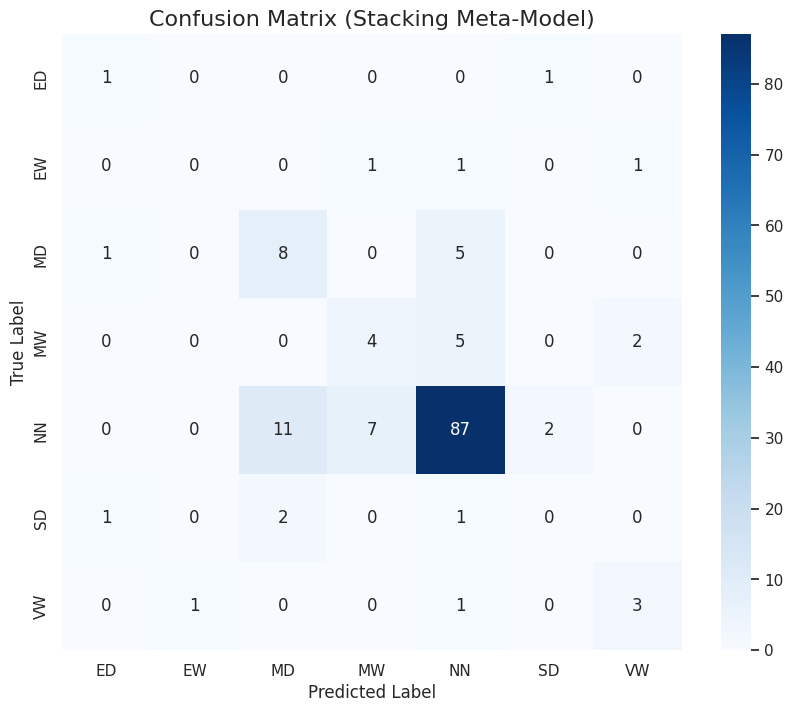

In [11]:
df['Month'] = df['Month'].astype('int')
df['month_sin'] = np.sin(2 * np.pi * df['Month']/12.0)
df['month_cos'] = np.cos(2 * np.pi * df['Month']/12.0)
df['Month'] = df['Month'].astype('category')
# X.drop(columns=['Month'], inplace=True)

# # تبدیل ستون های دسته ای به عددی
# for col in X.columns:
#     if pd.api.types.is_categorical_dtype(X[col]):
#         X[col] = X[col].astype(int)

# --- 3. Data Splitting and Feature Selection ---
class_counts = y.value_counts()
classes_to_remove = class_counts[class_counts < 2].index
if not classes_to_remove.empty:
    print(f"\nRemoving classes with fewer than 2 samples: {list(classes_to_remove)}")
    # پیدا کردن اندیس ردیف هایی که باید حذف شوند
    indices_to_remove = y[y.isin(classes_to_remove)].index
    # حذف ردیف ها از X و y
    X = X.drop(indices_to_remove)
    y = y.drop(indices_to_remove)
    print(f"New data shape after removing rare classes: {X.shape}")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

# انتخاب خودکار بهترین تعداد ویژگی با RFECV و اعمال محدودیت حداکثر
print("\n--- Performing Automatic Feature Selection with RFECV ---")
estimator = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
# تعریف محدودیت حداکثر برای تعداد ویژگی ها (مثلا 10)
max_features_cap = 6 

# RFECV بهترین تعداد ویژگی را بر اساس معیار f1_macro پیدا می کند
selector_cv = RFECV(estimator, step=1, cv=StratifiedKFold(3), scoring='f1_macro', min_features_to_select=3, n_jobs=-1)
selector_cv = selector_cv.fit(X_train, y_train)

optimal_n_features = selector_cv.n_features_
print(f"Optimal number of features found by RFECV: {optimal_n_features}")

# اگر تعداد بهینه از سقف تعیین شده بیشتر بود، از RFE برای انتخاب سقف استفاده می کنیم
if optimal_n_features > max_features_cap:
    print(f"Optimal number ({optimal_n_features}) is greater than the cap ({max_features_cap}).")
    print(f"Selecting top {max_features_cap} features using RFE.")
    # از RFE برای انتخاب تعداد مشخص استفاده می کنیم
    selector = RFE(estimator, n_features_to_select=max_features_cap, step=1)
    selector = selector.fit(X_train, y_train)
else:
    print("Optimal number is within the cap. Using RFECV selection.")
    selector = selector_cv # از همان انتخابگر RFECV استفاده می کنیم

selected_features = X_train.columns[selector.support_]
print("Final selected features:", list(selected_features))

# اعمال ویژگی های انتخاب شده به داده ها
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)


# --- 4. Data Balancing ---
print("\nBalancing training data with SMOTE...")
min_class_size = y_train.value_counts().min()
k_neighbors = max(1, min_class_size - 1)
smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_selected, y_train)


# --- 5. Build the Stacking Meta-Model ---
print("\nBuilding the Stacking model...")

# الف) تعریف مدل های پایه (Base Models)
estimators = [
    # ('rf', RandomForestClassifier(n_estimators=400, random_state=42, class_weight='balanced', n_jobs=-1)),
    # ('lgbm', LGBMClassifier(random_state=42, class_weight='balanced', n_jobs=-1)),
    # ('cat', CatBoostClassifier(random_state=42, verbose=0, auto_class_weights='Balanced')),
    ('xgb', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss', n_jobs=-1)),
    ('svc', make_pipeline(StandardScaler(), SVC(random_state=42, probability=True, class_weight='balanced'))),
    ('knn', make_pipeline(StandardScaler(), KNeighborsClassifier(n_jobs=-1))),
    ('gnb', GaussianNB())
]

# ب) تعریف مدل نهایی (Meta-Model)
# final_estimator = LogisticRegression(random_state=42, class_weight='balanced')
final_estimator = RandomForestClassifier(n_estimators=50, random_state=42, class_weight='balanced', n_jobs=-1)


# ج) ساخت مدل Stacking
stacking_model = StackingClassifier(
    estimators=estimators,
    final_estimator=final_estimator,
    cv=5,
    n_jobs=-1
)

# --- 6. Train the Stacking Model ---
print("\nTraining the final Stacking model...")
# مدل روی داده های متوازن و انتخاب شده آموزش می بیند
stacking_model.fit(X_train_resampled, y_train_resampled)

# --- 7. Prediction and Evaluation ---
print("\nEvaluating the final model...")
y_pred = stacking_model.predict(X_test_selected)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("\n--- Final Model Evaluation Metrics (Stacking Classifier) ---")
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(report)

# --- 8. Visualization ---
sns.set_theme(style="whitegrid")

# ماتریس درهم ریختگی
cm = confusion_matrix(y_test, y_pred, labels=stacking_model.classes_)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=stacking_model.classes_, yticklabels=stacking_model.classes_)
plt.title('Confusion Matrix (Stacking Meta-Model)', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()
